In [ ]:
"""
This script should extract the number of unique action we have over all users for the re-exposure experiment.
-> It is derived from the cells below to make the actual plot, if something is not working, you can check it out below.

Dependencies:
conda install jupyter
conda install pytorch==1.9.1 torchvision==0.10.1 cudatoolkit=11.3 -c pytorch -c conda-forge
# If dist_utils error, run: pip install setuptools==59.5.0
"""

import torch
import os

# Stored on EFS, either path should have the same nb of re-occurrences (can use either)
SGD_parent_outputdir = "/fb-agios-acai-efs/mattdl/results/ego4d_action_recog/forgetting_eval/logs/2022-09-23_21-12-33_UIDec506d45-3018-468f-b63a-89744c5d10f9/user_logs/"
replay_parent_outputdir = "/fb-agios-acai-efs/mattdl/results/ego4d_action_recog/forgetting_eval_replay/logs/NO_GRID/2022-10-22_00-33-32_UID17d7f432-ee2f-4312-8142-be019ea89b1a/user_logs"

parent_outputdir = replay_parent_outputdir # Choose one of the paths (arbitrary), from which the user-subdirs will be iterated to collect user results
dump_filename = "stream_info_dump.pth" # The name of the result-file in the user-subdir

# Tags for the paths
label_to_parent_dumpdir = {
    'SGD':SGD_parent_outputdir,
    'Replay':replay_parent_outputdir,
}

# Iterate over action/verb/noun
ylabel_map = {
    'train_action_past/FORG_EXPOSE_loss': r"RF - action",
    'train_verb_past/FORG_EXPOSE_loss': r"RF - verb",
    'train_noun_past/FORG_EXPOSE_loss': r"RF - noun",
}

for y_label_key, y_label in ylabel_map.items(): # Iterate action/verb/noun
    for method_label, dump_parentpath in  label_to_parent_dumpdir.items(): # Iterate Replay/SGD (methods)
        print(f"\n SUMMARY FOR {y_label}, method {method_label}")

        # Per method and (action/verb/noun): Summarize nb of classes
        userid_to_actions:dict = {}
        for idx, user_subdir in enumerate(os.scandir(parent_outputdir)): # Iterate User stream results (each a subdir)
            if not user_subdir.is_dir():
                continue
            user_dump_path = os.path.join(dump_parentpath, user_subdir.name, dump_filename) # The user-stream result
            assert os.path.isfile(user_dump_path)
            user_id = user_subdir.name.split('_')[-1] # Extract user-id from dirname

            dump = torch.load(user_dump_path) # Load dump dict
            results = dump[y_label_key] # Get the forgetting re-exposure result dict

            """
            result dict: is a dictionary containing 3 dictionaries that map actions to a list of iteration they were captured. The 'prev_after_update_iter' is the latest re-exposure, and at the same index, the 'current_before_update_iter' is the end of the re-exposure interval, hence we can calculate a delta in number of iterations (x-axis).
            The third key, the 'delta' key, is not the iteration-delta, but the actual forgetting delta (y-axis)

            Format:
                {
                'prev_after_update_iter': dict<action,value-list of iteration-start of re-exposure interval>
                'current_before_update_iter': dict<action,value-list of iteration-end of re-exposure interval>
                'delta': dict<action,value-list of forgetting>
                }
            """

            delta_dict = results['delta'] # Pick one of the three keys, and retrieve the actions
            action_set = set(delta_dict.keys())

            # Add
            userid_to_actions[user_id] = action_set
            print(f"user-{user_id}: {len(action_set)} unique classes")

        # Over all users unique classes
        total_action_set = set()
        for user_id, action_set in userid_to_actions.items():
            total_action_set.update(action_set)
        print(f"TOTAL over users: {len(total_action_set)} unique classes")


In [1]:
"""
From a Re-exposure forgetting experiment dump, make a plot.
"""
import os
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 1000)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [2]:
# FT vs Replay
SGD_parent_outputdir = "/fb-agios-acai-efs/mattdl/results/ego4d_action_recog/forgetting_eval/logs/2022-09-23_21-12-33_UIDec506d45-3018-468f-b63a-89744c5d10f9/user_logs/"
replay_parent_outputdir = "/fb-agios-acai-efs/mattdl/results/ego4d_action_recog/forgetting_eval_replay/logs/NO_GRID/2022-10-22_00-33-32_UID17d7f432-ee2f-4312-8142-be019ea89b1a/user_logs"

label_to_parent_dumpdir = {
    'SGD':SGD_parent_outputdir,
    'Replay':replay_parent_outputdir,
}

parent_outputdir = replay_parent_outputdir

# Use relative path in WSL issues
main_outdir = "../imgs"

# READ PATHS (Dumps)
user_dir_fmt = "user_{}"
dump_filename = "stream_info_dump.pth"




# Plot configs
plot_config = {
    "color": 'royalblue',
    "dpi": 600,
    "figsize": (6,6),
    "xlabel": "re-exposure iterations",
    "ylabel": "",
    "title": None
}

# KEYS
saved_dumpkeys = [
    'train_action_past/FORG_EXPOSE_loss',
    'train_action_past/FORG_EXPOSE_top1acc',

    'train_verb_past/FORG_EXPOSE_loss',
    'train_verb_past/FORG_EXPOSE_top1acc',
    'train_verb_past/FORG_EXPOSE_top5acc',
    'train_verb_past/FORG_EXPOSE_top20acc',

    'train_noun_past/FORG_EXPOSE_loss',
    'train_noun_past/FORG_EXPOSE_top1acc',
    'train_noun_past/FORG_EXPOSE_top5acc',
    'train_noun_past/FORG_EXPOSE_top20acc'
]
CHOSEN_KEY = 'train_action_past/FORG_EXPOSE_loss'

# Adapt cfg
ylabel_map = {
    'train_action_past/FORG_EXPOSE_loss': r"RF_action",
    'train_verb_past/FORG_EXPOSE_loss': r"RF_verb",
    'train_noun_past/FORG_EXPOSE_loss': r"RF_noun",
#     'train_action_past/FORG_EXPOSE_loss': r"$RF_{\text{action}}$",
}
plot_config['ylabel'] = ylabel_map[CHOSEN_KEY]


METHOD=SGD, y_label_key=train_action_past/FORG_EXPOSE_loss
$\rho = 0.19$
$\text{avg. RF} = 1.27 \pm 0.13$
MEAN-DELTA=2.635634065339402, SE=0.26387680053020485
bin_means=[1.24919252 2.42149525 1.2377093  3.11452069 2.55566095 4.20785934
 5.05203791 3.05091737 3.90879446 6.56115396]
bin_sems=[0.46181248 0.58676957 0.60203203 0.80273748 0.92209229 0.96441592
 0.92968519 1.24417309 2.19980649 3.53802266]
bin_boundaries=[0.         0.22600714 0.45201428 0.67802142 0.90402856 1.13003569
 1.35604283 1.58204997 1.80805711 2.03406425 2.26007139]
bin_counts=[162. 105. 129. 104.  55.  70.  79.  46.  24.   8.]


<ErrorbarContainer object of 3 artists>

METHOD=Replay, y_label_key=train_action_past/FORG_EXPOSE_loss
$\rho = -0.2$
$\text{avg. RF} = -0.3 \pm 0.1$
MEAN-DELTA=-0.6282356917722894, SE=0.20293287744200192
bin_means=[-0.11328552  0.04075279 -0.81302757  0.40292207  0.23642405 -1.66204436
 -0.43770228 -2.68204191 -4.70043199 -5.01598525]
bin_sems=[0.35484277 0.41775482 0.42278363 0.58593014 0.82311735 0.68796467
 0.65580757 1.12757079 2.11422602 1.95993447]
bin_boundaries=[0.         0.22600714 0.45201428 0.67802142 0.90402856 1.13003569
 1.35604283 1.58204997 1.80805711 2.03406425 2.26007139]
bin_counts=[162. 105. 129. 104.  55.  70.  79.  46.  24.   8.]


<ErrorbarContainer object of 3 artists>

[Text(0.5, 0, 're-exposure iterations (bins)'), Text(0, 0.5, 'RF - action')]

([<matplotlib.axis.XTick at 0x7fcbc91f9880>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '5'),
  Text(3, 0, '8'),
  Text(4, 0, '13'),
  Text(5, 0, '23'),
  Text(6, 0, '38'),
  Text(7, 0, '64'),
  Text(8, 0, '108'),
  Text(9, 0, '182')])

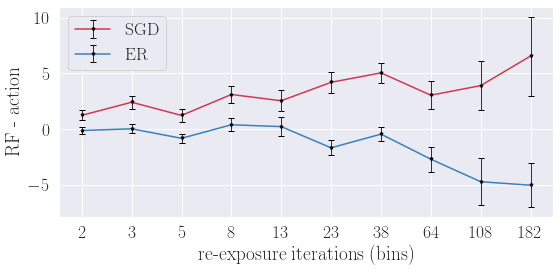

METHOD=SGD, y_label_key=train_verb_past/FORG_EXPOSE_loss
$\rho = 0.32$
$\text{avg. RF} = 1.58 \pm 0.09$
MEAN-DELTA=3.9111775521409724, SE=0.18260607629772557
bin_means=[2.49566334 4.13079881 4.70646165 4.63242043 3.58745029 4.22904886
 5.65255582 5.14421181 6.98833713 6.281859  ]
bin_sems=[0.22499037 0.36196758 0.56286086 0.61301599 0.5721019  0.67658496
 1.19800755 1.28928415 1.74101017 2.48871251]
bin_boundaries=[0.         0.20569049 0.41138097 0.61707146 0.82276194 1.02845243
 1.23414291 1.4398334  1.64552388 1.85121437 2.05690485]
bin_counts=[238. 127. 131.  62.  54.  66.  27.  28.  19.   7.]


<ErrorbarContainer object of 3 artists>

METHOD=Replay, y_label_key=train_verb_past/FORG_EXPOSE_loss
$\rho = -0.04$
$\text{avg. RF} = 0.39 \pm 0.05$
MEAN-DELTA=0.9504131552971601, SE=0.1145011485580182
bin_means=[ 1.25549916  1.29718478  1.23691341  1.48982608  0.73699011 -0.36574415
  0.3542377  -0.50460143 -0.29370145 -0.30087984]
bin_sems=[0.18723922 0.19409389 0.29895406 0.3599422  0.46205242 0.41974513
 0.67337147 0.6993498  1.08675476 2.17848539]
bin_boundaries=[0.         0.20569049 0.41138097 0.61707146 0.82276194 1.02845243
 1.23414291 1.4398334  1.64552388 1.85121437 2.05690485]
bin_counts=[238. 127. 131.  62.  54.  66.  27.  28.  19.   7.]


<ErrorbarContainer object of 3 artists>

[Text(0.5, 0, 're-exposure iterations (bins)'), Text(0, 0.5, 'RF - verb')]

([<matplotlib.axis.XTick at 0x7fcbca1993a0>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '7'),
  Text(4, 0, '11'),
  Text(5, 0, '17'),
  Text(6, 0, '28'),
  Text(7, 0, '44'),
  Text(8, 0, '71'),
  Text(9, 0, '114')])

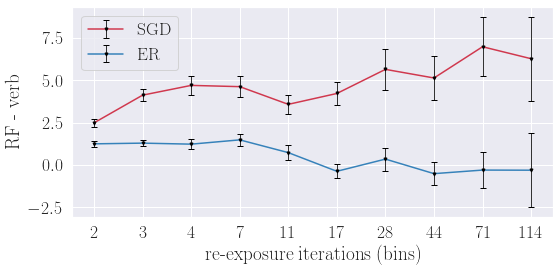

METHOD=SGD, y_label_key=train_noun_past/FORG_EXPOSE_loss
$\rho = 0.31$
$\text{avg. RF} = 1.55 \pm 0.12$
MEAN-DELTA=4.5108980423079315, SE=0.30997971658806633
bin_means=[2.65384951 3.30533068 3.4734792  4.51409992 4.37433369 8.96411992
 8.13622302 9.32823069 4.36929256 1.17504644]
bin_sems=[0.4001545  0.8256801  0.8128077  0.64747732 1.09151503 1.36983078
 1.39721694 1.55336501 2.48037402 3.54761791]
bin_boundaries=[0.         0.2307496  0.46149921 0.69224881 0.92299842 1.15374802
 1.38449762 1.61524723 1.84599683 2.07674643 2.30749604]
bin_counts=[144.  64.  83.  66.  38.  47.  42.  17.   8.   2.]


<ErrorbarContainer object of 3 artists>

METHOD=Replay, y_label_key=train_noun_past/FORG_EXPOSE_loss
$\rho = -0.07$
$\text{avg. RF} = 0.23 \pm 0.07$
MEAN-DELTA=0.6656633677428341, SE=0.18829808613358445
bin_means=[ 0.85692787  0.73173087  0.53706285  1.41174508  0.4041386   0.17387115
  0.80943708  0.54230226 -3.19877634 -4.490148  ]
bin_sems=[0.29648678 0.53837639 0.42466126 0.47868694 0.66880966 0.77107058
 0.77915968 1.51793592 1.96245796 2.96008826]
bin_boundaries=[0.         0.2307496  0.46149921 0.69224881 0.92299842 1.15374802
 1.38449762 1.61524723 1.84599683 2.07674643 2.30749604]
bin_counts=[144.  64.  83.  66.  38.  47.  42.  17.   8.   2.]


<ErrorbarContainer object of 3 artists>

[Text(0.5, 0, 're-exposure iterations (bins)'), Text(0, 0.5, 'RF - noun')]

([<matplotlib.axis.XTick at 0x7fcbc9446e20>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '5'),
  Text(3, 0, '8'),
  Text(4, 0, '14'),
  Text(5, 0, '24'),
  Text(6, 0, '41'),
  Text(7, 0, '70'),
  Text(8, 0, '119'),
  Text(9, 0, '203')])

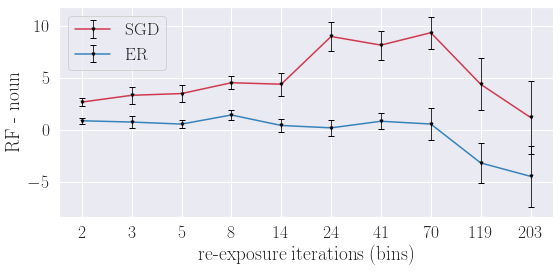

In [42]:
import datetime
import numpy as np

sns.set(font_scale=1.6)
# plt.rcParams['font.family'] = 'DeJavu Serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

# Set fonts
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 14

# Use latex in mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

# Set latex font in mpl
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


# Adapt cfg
ylabel_map = {
    'train_action_past/FORG_EXPOSE_loss': r"RF - action",
    'train_verb_past/FORG_EXPOSE_loss': r"RF - verb",
    'train_noun_past/FORG_EXPOSE_loss': r"RF - noun",
#     'train_action_past/FORG_EXPOSE_loss': r"$RF_{\text{action}}$",
}

# naem to color
name_to_color = {
    'SGD':sns.color_palette("Spectral",10)[0],
    'Replay': sns.color_palette("Spectral",10)[9],
}
name_to_legend_name = {
    'SGD': 'SGD',
    'Replay': 'ER',
}

log_scale = True
nb_bins = 10

title = "FORG_REEXPOSURE_SGD_VS_REPLAY"
parent_dirname = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "_" + title
parent_dirpath = os.path.join(main_outdir, title, parent_dirname)

def add_to_df(action_results_over_time: dict, df_row_list, user_id) :
    """
    :param: action_results_over_time: is a dictionary containing two dictionaries that map actions to a list of iteration they were captured. The 'prev_after_update_iter' is the latest re-exposure, and at the same index, the 'current_before_update_iter' is the end of the re-exposure interval, hence we get a delta in number of iterations.
    {
    'prev_after_update_iter': dict<action,value-list of iteration-start of re-exposure interval>
    'current_before_update_iter': dict<action,value-list of iteration-end of re-exposure interval>
    'delta': dict<action,value-list of forgetting>
    }
    """
    assert len(action_results_over_time["delta"]) > 0  # Don't log if state is not kept

    # Get deltas on x-axis
    deltas_x_per_action = defaultdict(list)
    for action, prev_res_over_time in action_results_over_time["prev_after_update_iter"].items():
        cur_res_over_time: list = action_results_over_time["current_before_update_iter"][action]
        for prev_t, new_t in zip(prev_res_over_time, cur_res_over_time):
            assert new_t >= prev_t, f"New iteration {new_t} <= prev iteration {prev_t}"
            deltas_x_per_action[action].append(new_t - prev_t)

    # Get values on y-axis
    deltas_y_per_action = action_results_over_time["delta"]


    for action, deltas_x in deltas_x_per_action.items():
        deltas_y = deltas_y_per_action[action]
        
        for delta_x, delta_y in zip(deltas_x,deltas_y):
            df_row_list.append({'user':user_id,'iter_delta':delta_x,'forg':delta_y, 'action':action})
#         plt.scatter(deltas_x, deltas_y, color=plot_config['color'])

for y_label_key in ylabel_map.keys(): # Iterate action/verb/noun
    
    # Figure to 
    fig, ax = plt.subplots(figsize=(8, 4))
    for method_label, dump_parentpath in  label_to_parent_dumpdir.items(): # Iterate Replay/SGD (methods)
        print(f"METHOD={method_label}, y_label_key={y_label_key}")
        plot_config['ylabel'] = ylabel_map[y_label_key]

        df_row_list:list[dict] = []
        for idx, user_subdir in enumerate(os.scandir(parent_outputdir)): # Iterate User stream results (each a subdir)
            if not user_subdir.is_dir():
                continue
            user_dump_path = os.path.join(dump_parentpath, user_subdir.name, dump_filename) # The user-stream result
            assert os.path.isfile(user_dump_path)
            user_id = user_subdir.name.split('_')[-1]

            dump = torch.load(user_dump_path)
            results = dump[y_label_key]

            add_to_df(results, df_row_list, user_id)

        df = pd.DataFrame(df_row_list)

        # Get CORRELATIOn

        corr = scipy.stats.pearsonr(df.iter_delta, df.forg,)
    #     print(f"CORR={corr}")

        print(fr"$\rho = {round(corr[0],2)}$")
        print(fr"$\text{{avg. RF}} = {round(df.forg.mean(),2)} \pm {round(df.forg.sem(),2)}$")
        # PLOTS

        # Filter without 0-iter entries
        df = df.loc[df.iter_delta > 0]
        
        # TODO print average and SEM (without zero-iteration entries)
        avg = df.forg.mean()
        sem = df.forg.sem()
        print(f"MEAN-DELTA={avg}, SE={sem}")

            # To log-scale
        if log_scale:
            df.iter_delta = np.log10(df.iter_delta)
            #df.forg = np.log10(df.forg) # Negative and 0 -> inf

        vals_to_bin = df.iter_delta
        stat_values = df.forg
        bin_means, bin_boundaries, _ = scipy.stats.binned_statistic(vals_to_bin, stat_values, statistic='mean', bins=nb_bins, range=None)
        bin_sems, *_ = scipy.stats.binned_statistic(vals_to_bin, stat_values, statistic=scipy.stats.sem, bins=nb_bins, range=None)
        bin_counts, *_ = scipy.stats.binned_statistic(vals_to_bin, stat_values, statistic='count', bins=nb_bins, range=None)

        print(f"bin_means={bin_means}")
        print(f"bin_sems={bin_sems}")
        print(f"bin_boundaries={bin_boundaries}")
        print(f"bin_counts={bin_counts}")



    #     x_bin_vals = [round(x,1) for x in bin_boundaries[1:]] # Still log iterations? Not making a lot of sense
        x_bin_vals = [round(10**x) for x in bin_boundaries[1:]] # De-logscale
        x_vals = range(len(x_bin_vals))
        plt.errorbar(x_vals, bin_means, yerr=bin_sems,color=name_to_color[method_label],
                    capsize=3, elinewidth=0.8, 
                     markersize=3, marker='v',mfc='black',mec='black',
#                      markeredgewidth=1,
                     ecolor='black',
                     label=name_to_legend_name[method_label],
                    )

        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]

    
    # FINAL PLOT SETTINGS
    ax.set(xlabel='re-exposure iterations (bins)', ylabel=plot_config['ylabel'])
    plt.xticks(x_vals, x_bin_vals, rotation='horizontal')
#     ax.set_xticklabels()

#         plt.ylim(0, None)
#     plt.xlim(-3, None)
    
#     ax.grid(axis='x')
    ax.grid(True)

    # TODO: LEGEND
    leg = ax.legend()
    

    plt.tight_layout()

    filename = plot_config['ylabel'].replace(' ','') + '.pdf'
    filepath = os.path.join(parent_dirpath,filename)
    os.makedirs(parent_dirpath, exist_ok=True)
    fig.savefig(filepath)

    plt.show()
    plt.close('all')
    
    
